Applied

8. In this exercise, we will generate simulated data, and will then use
this data to perform forward and backward stepwise selection.
(a) Create a random number generator and use its normal() method
to generate a predictor X of length n = 100, as well as a noise
vector ϵ of length n = 100.

In [9]:
import numpy as np
import pandas as pd
from functools import partial
from statsmodels.api import OLS
import statsmodels.api as sm
from ISLP.models import Stepwise
from ISLP.models import ModelSpec as MS
from ISLP.models import sklearn_selected
from ISLP.models import summarize
from ISLP.models import sklearn_selection_path
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from ISLP import load_data
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.cross_decomposition import PLSRegression
from l0bnb import fit_path


In [2]:
rng = np.random.default_rng(1)
X = rng.normal(size=100)
noise = rng.normal(scale=0.2,size=100)

(b) Generate a response vector Y of length n = 100 according to
the model
Y = β0 + β1X + β2X2 + β3X3 + ϵ,
where β0, β1, β2, and β3 are constants of your choice.

In [3]:
b0 = 5
b1 = 0.5
b2 = 2
b3 = -3

Y = b0 + b1*X + b2 * X**2 + b3 * X**3 + noise

(c) Use forward stepwise selection in order to select a model containing the predictors X, X2, . . . , X10. What is the model obtained
according to Cp? Report the coefficients of the model obtained.

In [4]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 


In [5]:
X = pd.DataFrame({'degree 1':X[0]})
X_new = X.copy()
for i in range(2, 11):
    for col in X.columns:
        X_new[f'degree {i}'] = np.power(X[col], i)
X_new

ValueError: If using all scalar values, you must pass an index

In [236]:
design = MS(X_new.columns).fit(X_new)
X2 = design.transform(X_new)


In [237]:
design.terms

Index(['degree 1', 'degree 2', 'degree 3', 'degree 4', 'degree 5', 'degree 6',
       'degree 7', 'degree 8', 'degree 9', 'degree 10'],
      dtype='object')

In [239]:
X_new.columns

Index(['degree 1', 'degree 2', 'degree 3', 'degree 4', 'degree 5', 'degree 6',
       'degree 7', 'degree 8', 'degree 9', 'degree 10'],
      dtype='object')

In [240]:
sigma2 = OLS(Y,X2).fit().scale
neg_Cp = partial(nCp,sigma2)

In [270]:
strategy = Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms))

y_cp = sklearn_selected(OLS,strategy=strategy,scoring=neg_Cp)
y_cp.fit(X_new,Y)
y_cp.selected_state_

('degree 1', 'degree 10', 'degree 2', 'degree 3')

In [254]:
results = sm.OLS(Y,X2[['intercept','degree 1','degree 2','degree 3','degree 10']]).fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,5.010700,0.024000,210.562,0.000
degree 1,0.455100,0.041000,11.054,0.000
degree 2,1.951800,0.022000,87.872,0.000
degree 3,-2.977600,0.016000,-190.361,0.000
degree 10,0.000054,0.000016,3.304,0.001


(d) Repeat (c), using backwards stepwise selection. How does your
answer compare to the results in (c)?

- Degree 1,2,3,6,8 is chosen by backward instead of 1, 2, 3, 10.

In [286]:
strategy_backward = Stepwise.first_peak(design,'backward',min_terms=6,max_terms=len(design.terms))
y_Cp_backward = sklearn_selected(OLS,strategy=strategy_backward,scoring=neg_Cp)
y_Cp_backward.fit(X_new,Y)
y_Cp_backward.selected_state_

()

In [295]:
model = LinearRegression()
selector = SequentialFeatureSelector(model, direction='backward',scoring=neg_Cp)
selector.fit(X_new, Y)
selected_features = selector.support_
print("Selected features:", selected_features)

Selected features: [ True  True  True False False  True False  True False False]


(e) Now fit a lasso model to the simulated data, again using X, X2,
. . . , X10 as predictors. Use cross-validation to select the optimal
value of λ. Create plots of the cross-validation error as a function
of λ. Report the resulting coefficient estimates, and discuss the
results obtained.

In [ ]:
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
lambdas

In [308]:
kfold = skm.KFold(5,shuffle=True,random_state=0)
lassoCV = skl.ElasticNetCV(n_alphas=100,l1_ratio=1,cv=kfold)
scaler = StandardScaler(with_mean=True,with_std=True)
pipeCV = Pipeline(steps=[('scaler',scaler),('lasso',lassoCV)])
pipeCV.fit(X2,Y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=1))])

In [321]:
tuned_lasso.intercept_

7.637746874597183

In [322]:
tuned_lasso.coef_

array([ 0.        ,  0.25849086,  2.32729725, -8.20276688,  0.        ,
       -0.38774411,  0.        , -0.        ,  0.        , -0.        ,
        0.        ])

In [309]:
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.009564874290205786

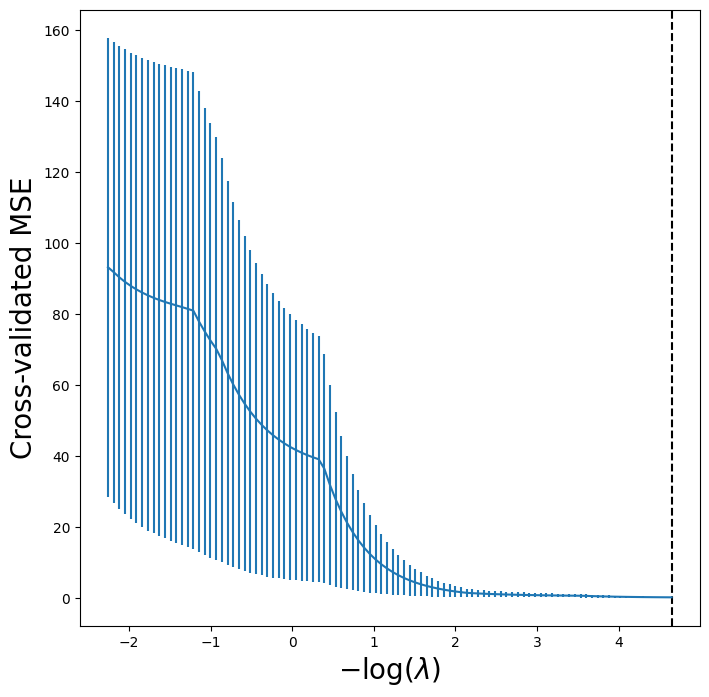

In [319]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(5))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

(f) Now generate a response vector Y according to the model
Y = β0 + β7X7 + ϵ,
and perform forward stepwise selection and the lasso. Discuss
the results obtained.

In [338]:
Y_new = b0 + X_new['degree 7'] * tuned_lasso.coef_[6]  + noise

In [339]:
strategy_forward = Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms))

model = sklearn_selected(OLS,strategy_forward,scoring=neg_Cp)
model.fit(X2,Y_new)
model.selected_state_


('degree 10', 'degree 4', 'degree 7')

In [340]:
lasso = skl.ElasticNetCV(n_alphas=100,l1_ratio=1,cv=kfold)
pipe = Pipeline(steps=[('scaler',scaler),('lasso',lasso)])
pipe.fit(X2,Y_new)
tuned_lasso_new = pipe.named_steps['lasso']

c:\Users\akbas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022627016336387307, tolerance: 0.00034854136986781374
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\akbas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004171530117275335, tolerance: 0.00034854136986781374
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\akbas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025012961155788105, tolerance: 0.00034854136986781374
  model = cd_fast.enet_coo

In [341]:
tuned_lasso_new.intercept_

4.985257437696734

In [342]:
tuned_lasso_new.coef_

array([ 0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.])

9. In this exercise, we will predict the number of applications received
using the other variables in the College data set.

(a) Split the data set into a training set and a test set.

In [348]:
college = load_data('College')
college.columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate'],
      dtype='object')

In [362]:
X_college = college.drop(['Apps'],axis=1)
y_college = college.Apps

In [368]:
X_college['private01'] = 0
index = X_college['Private'] == 'Yes'
X_college.private01[index] = 1

C:\Users\akbas\AppData\Local\Temp\ipykernel_9804\2779010837.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_college.private01[index] = 1
C:\Users\akbas\AppData\Local\Temp\ipykernel_9804\2779010837.py:3: SettingWithCopyWarning: 
A value

In [369]:
X_college

,Private,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,private01
0,Yes,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
1,Yes,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1
2,Yes,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1
3,Yes,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1
4,Yes,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,No,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40,0
773,Yes,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83,1
774,Yes,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49,1
775,Yes,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99,1


In [ ]:
X_college = X_college.drop('Private',axis=1)

In [372]:
X_college

,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,private01
0,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
1,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1
2,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1
3,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1
4,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40,0
773,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83,1
774,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49,1
775,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99,1


In [373]:
X_train, X_test, y_train, y_test = train_test_split(X_college,y_college,test_size=0.25,random_state=0)

(b) Fit a linear model using least squares on the training set, and
report the test error obtained.

In [375]:
least_squares = LinearRegression()
least_squares.fit(X_train,y_train)
least_squares.coef_

array([ 1.62414445e+00, -1.03593047e+00,  5.72126086e+01, -1.73420284e+01,
        7.23896089e-02,  5.33735899e-02, -7.60788115e-02,  1.77204871e-01,
        1.44747398e-02, -1.15445326e-02, -1.11582493e+01, -3.07620702e+00,
        3.74793091e+00,  6.74196792e-01,  4.73622897e-02,  8.37369625e+00,
       -5.63468969e+02])

In [381]:
preds = least_squares.predict(X_test)
test_error = mean_squared_error(preds,y_test)
test_error 

1022430.0889255279

In [382]:
np.sqrt(test_error)

1011.1528514154168

(c) Fit a ridge regression model on the training set, with λ chosen
by cross-validation. Report the test error obtained.

In [389]:
alphas = np.logspace(-6,6,100)
ridge = RidgeCV(alphas=alphas,cv=kfold)
pipe_college = Pipeline(steps=[('scaler',scaler),('ridge',ridge)])
pipe_college.fit(X_train,y_train)
ridge_preds = pipe_college.predict(X_test)

test_error_ridge = np.sqrt(mean_squared_error(ridge_preds,y_test))
test_error_ridge

1005.1049688795059

In [390]:
tuned_ridge = pipe_college.named_steps['ridge']
tuned_ridge.alpha_

1.5199110829529332

In [393]:
tuned_ridge.intercept_

3080.6855670103087

In [391]:
tuned_ridge.coef_

array([ 4.08973913e+03, -8.62743880e+02,  9.77138280e+02, -3.15007503e+02,
        3.15731334e+02,  8.72726433e+01, -2.88785490e+02,  1.96546086e+02,
        3.02324436e+00, -9.44140547e+00, -1.77938515e+02, -4.88814648e+01,
        1.62334505e+01,  2.53383605e-01,  2.53955278e+02,  1.44868627e+02,
       -2.54513776e+02])

(d) Fit a lasso model on the training set, with λ chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [394]:
college_lasso = skl.ElasticNetCV(l1_ratio=1,n_alphas=100,cv=kfold)
pipe_college_lasso = Pipeline(steps=[('scaler',scaler),('lasso',college_lasso)])
pipe_college_lasso.fit(X_train,y_train)

tuned_lasso_college = pipe_college_lasso.named_steps['lasso']
tuned_lasso_college.coef_


array([3788.14296337, -210.42595244,  635.52718931,  -32.25348584,
         -0.        ,   37.48371288, -143.1022138 ,  151.58867891,
          0.        ,   -0.        , -116.95313817,  -42.99961843,
          0.        ,   -0.        ,  211.3047556 ,   58.06026125,
       -212.59410092])

In [395]:
college_lasso_preds = pipe_college_lasso.predict(X_test)
college_lasso_test_error = np.sqrt(mean_squared_error(college_lasso_preds,y_test))
college_lasso_test_error

1008.2691610635471

(e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value
of M selected by cross-validation.

In [398]:
pca = PCA()
linreg = skl.LinearRegression()
pipe_pca = Pipeline(steps=[('scaler',scaler),('pca',pca),('linreg',linreg)]) 
param_grid = {'pca__n_components':range(1,20)}
grid = skm.GridSearchCV(pipe_pca,param_grid=param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)


c:\Users\akbas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\akbas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\akbas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\akbas\AppData

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

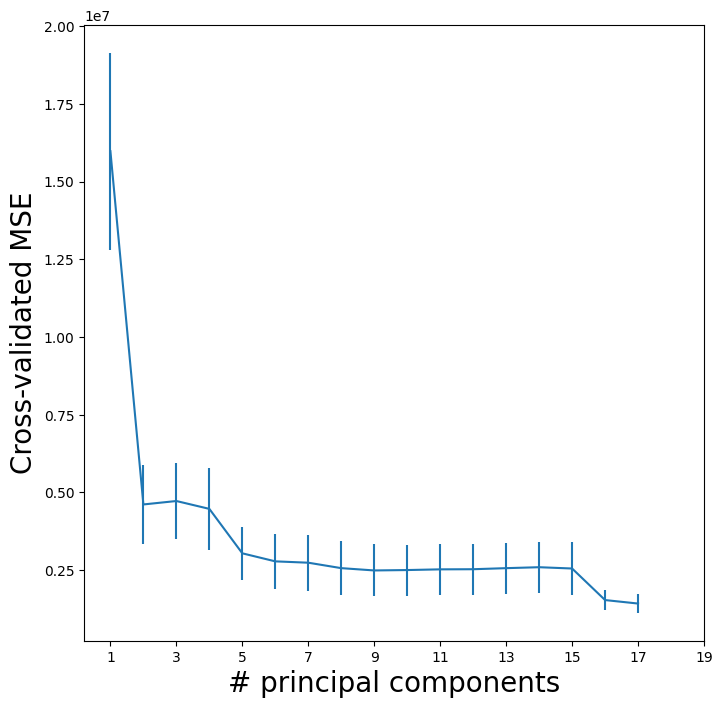

In [400]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])

In [408]:
M = 17
pca = PCA(n_components=M)
pipe_pca = Pipeline(steps=[('scaler',scaler),('pca',pca),('linreg',linreg)])
pipe_pca.fit(X_train,y_train)

pca_preds = pipe_pca.predict(X_test)
pca_test_error = np.sqrt(mean_squared_error(pca_preds,y_test))
pca_test_error

1011.1528514154246

(f) Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value
of M selected by cross-validation

In [ ]:
pls = PLSRegression()
param_grid = {'n_components':range(1,20)}
grid_pls = skm.GridSearchCV(pls,param_grid=param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid_pls.fit(X_train,y_train)



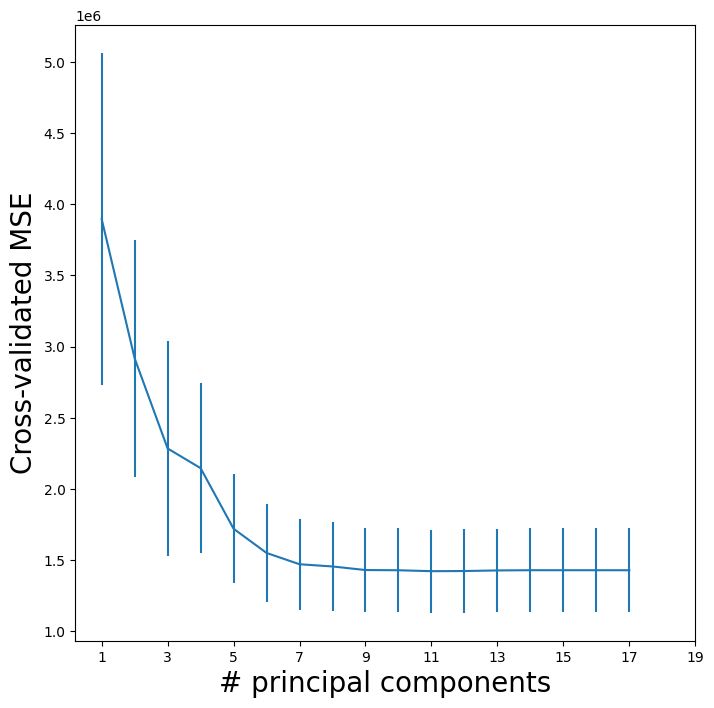

In [412]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid_pls.cv_results_['mean_test_score'],
            grid_pls.cv_results_['std_test_score'] / np.sqrt(5))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])

In [415]:
M = 9
pls = PLSRegression(n_components=M)
pipe_pls = Pipeline(steps=[('scaler',scaler),('pls',pls)])
pipe_pls.fit(X_train,y_train)

pipe_pls_preds = pipe_pls.predict(X_test)
pipe_pls_test_error = np.sqrt(mean_squared_error(pipe_pls_preds,y_test))
pipe_pls_test_error

1011.2261799666595

(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much
difference among the test errors resulting from these five approaches?

- There was not a lot of difference resulting from these 5 approaches, but lasso gave the best test MSE.

11. We will now try to predict per capita crime rate in the Boston data
set.

(a) Try out some of the regression methods explored in this chapter,
such as best subset selection, the lasso, ridge regression, and
PCR. Present and discuss results for the approaches that you
consider.

In [7]:
boston = load_data('Boston')
boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [62]:
X = np.asarray(boston.drop(labels='crim',axis=1))
y = np.asarray(boston.crim)
X_train,X_test, y_train,y_test = train_test_split(X,y,shuffle=True)

In [21]:
X

array([[18.  ,  2.31,  0.  , ..., 15.3 ,  4.98, 24.  ],
       [ 0.  ,  7.07,  0.  , ..., 17.8 ,  9.14, 21.6 ],
       [ 0.  ,  7.07,  0.  , ..., 17.8 ,  4.03, 34.7 ],
       ...,
       [ 0.  , 11.93,  0.  , ..., 21.  ,  5.64, 23.9 ],
       [ 0.  , 11.93,  0.  , ..., 21.  ,  6.48, 22.  ],
       [ 0.  , 11.93,  0.  , ..., 21.  ,  7.88, 11.9 ]])

In [72]:
boston_path = fit_path(X,y,max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  4
Iteration: 4. Number of non-zeros:  8
Iteration: 5. Number of non-zeros:  10
Iteration: 6. Number of non-zeros:  12


In [74]:
boston_path

[{'B': array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.60579503, 0.        , 0.        ,
         0.        , 0.        ]),
  'B0': -2.171459781533433,
  'lambda_0': 0.18987456856984775,
  'M': 0.6132403384927473,
  'Time_exceeded': False},
 {'B': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.54079338,  0.        ,  0.        ,
          0.        , -0.16448136]),
  'B0': 2.1554940314563336,
  'lambda_0': 0.011921068504802297,
  'M': 0.7358884061912964,
  'Time_exceeded': False},
 {'B': array([ 0.03741948,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -0.40007448,  0.49485431,  0.        ,  0.        ,
          0.24096552,  0.        ]),
  'B0': -3.0679152802285543,
  'lambda_0': 0.0020684054987485812,
  'M': 0.6569277750104398,
  'Time_exceeded': False},
 {'B': array([ 0.04216881,  0.        , -0.92035428, -9.45405916,  0.        ,
        

In [90]:
boston_path[3]

{'B': array([ 0.04216881,  0.        , -0.92035428, -9.45405916,  0.        ,
         0.        , -0.83770967,  0.53462819,  0.        , -0.28288165,
         0.12531484, -0.16577504]),
 'B0': 13.886367023836653,
 'lambda_0': 0.001863496308796381,
 'M': 0.60112336748906,
 'Time_exceeded': False}

In [29]:
kfold = skm.KFold(n_splits=5,shuffle=True,random_state=0)
scaler = StandardScaler()
boston_lasso = skl.ElasticNetCV(l1_ratio=1,n_alphas=100,cv=kfold)
boston_lasso_pipe = Pipeline(steps=[('scaler',scaler),('lasso',boston_lasso)])
boston_lasso_pipe.fit(X,y)
boston_lasso_tuned = boston_lasso_pipe.named_steps['lasso']

In [87]:
mse_path = boston_lasso_tuned.mse_path_
mean_mse = np.mean(mse_path, axis=1)  
best_alpha_index = np.argmin(mean_mse)  # Find the index of the best alpha
best_mse = mean_mse[best_alpha_index] 
best_mse

42.84938685946365

In [30]:
boston_lasso_tuned.coef_

array([ 0.87524488, -0.44838042, -0.17015144, -0.79534969,  0.29383613,
       -0.        , -1.70032517,  4.69600355, -0.        , -0.4868067 ,
        0.95953556, -1.65563368])

In [48]:
lambdas, soln_array = skl.Lasso.path(X, 
                                    y,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=boston.drop(columns='crim').columns,
                         index=-np.log(lambdas))

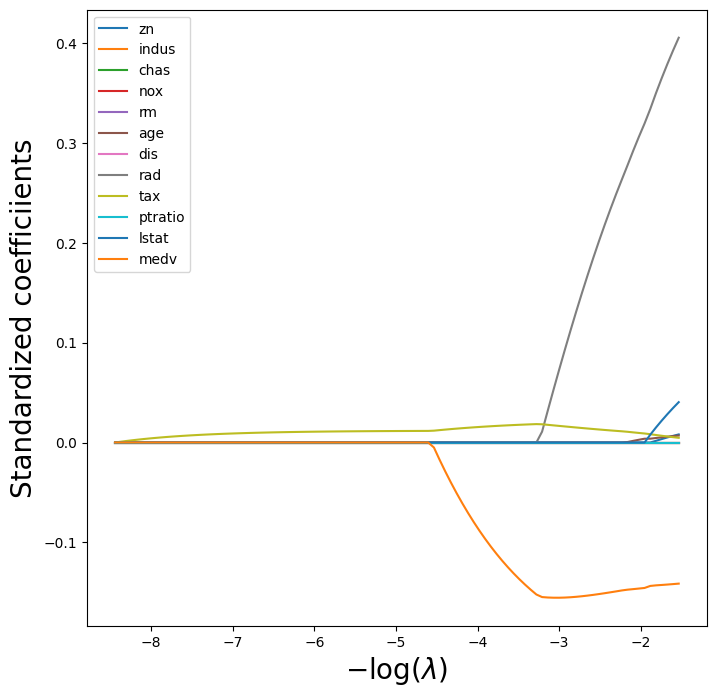

In [49]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [54]:
alphas = np.logspace(-6,6,100)
boston_ridge = RidgeCV(alphas=alphas,store_cv_values=True)
boston_ridge_pipe = Pipeline(steps=[('scaler',scaler),('ridge',boston_ridge)])
boston_ridge.fit(X,y)
boston_ridge_tuned = boston_ridge_pipe.named_steps['ridge']
boston_ridge_tuned.alpha_

0.37649358067924715

In [55]:
boston_ridge_tuned.coef_

array([ 4.57888649e-02, -6.68919527e-02, -8.43156611e-01, -7.94854127e+00,
        6.27988521e-01, -2.59892633e-03, -9.77345347e-01,  6.06878532e-01,
       -3.85807375e-03, -2.77665674e-01,  1.39618127e-01, -2.15375335e-01])

In [76]:
boston_pca = PCA()
linreg = LinearRegression()
boston_pca_pipe = Pipeline(steps=[('scaler',scaler),('pca',boston_pca),('linreg',linreg)])

param_grid = {'pca__n_components':range(1,20)}
grid = skm.GridSearchCV(boston_pca_pipe,param_grid=param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X,y)


c:\Users\akbas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
35 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\akbas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\akbas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\akbas\AppData

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

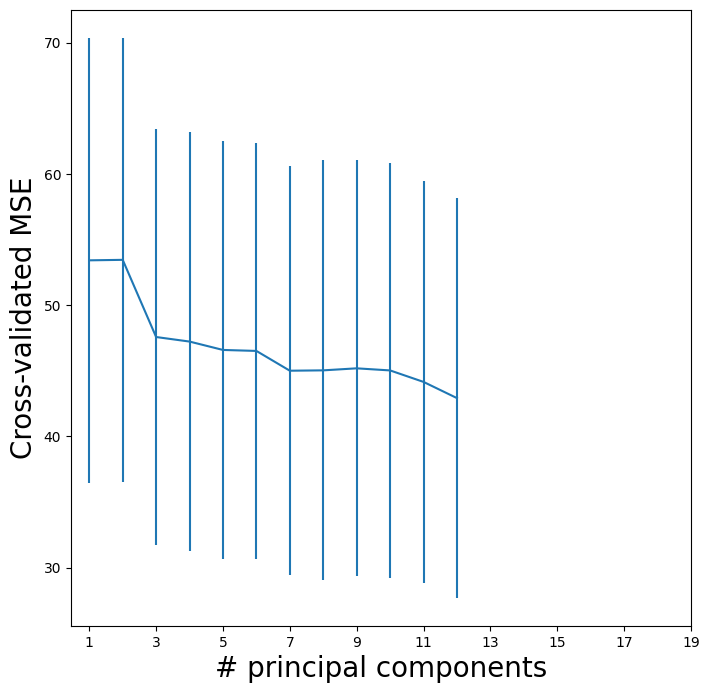

In [79]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])

In [88]:
pca = PCA(n_components=12)
boston_pca_pipe = Pipeline(steps=[('scaler',scaler),('pca',pca),('linreg',linreg)])
boston_pca_pipe.fit(X,y)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=12)),
                ('linreg', LinearRegression())])

(b) Propose a model (or set of models) that seem to perform well on
this data set, and justify your answer. Make sure that you are
evaluating model performance using validation set error, crossvalidation, or some other reasonable alternative, as opposed to
using training error.

- I prefer chosing from best subset selection since it exhaustively search the whole subsets of features, and selects the one with best score.

(c) Does your chosen model involve all of the features in the data
set? Why or why not?

- No it does not, it means not all features are necessary to predict the crime rate and they can increase MSE.